In [1]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to reconstruct MR images on a coil-by-coil basis
# and how to combine the image information from the different receiver coils
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of May 2017
# Author: Christoph Kolbitsch
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'

# import engine module
import pGadgetron as pMR

# import further modules
import os, numpy
%matplotlib
import matplotlib.pyplot as plt



Using matplotlib backend: TkAgg


In [2]:
#%% GO TO MR FOLDER
os.chdir(pMR.petmr_data_path('mr'))



In [3]:
#%% LOAD AND PREPROCESS RAW MR DATA
acq_data = pMR.AcquisitionData('simulated_MR_2D_cartesian.h5')
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)




In [4]:
#%% CHECK IF K-SPACE DATA IS SORTED
print('Is k-space data sorted? %s' % preprocessed_data.is_sorted())




Is k-space data sorted? False


In [5]:
#%% SORT K-SPACE DATA
preprocessed_data.sort()
print('Is k-space data sorted? %s' % preprocessed_data.is_sorted())




Is k-space data sorted? True


In [6]:
#%% RETRIEVE K-SPACE DATA
k_array = preprocessed_data.as_array()
print('Size of k-space %dx%dx%d' % k_array.shape)




Size of k-space 512x8x256


Size of k-space 256x8x256


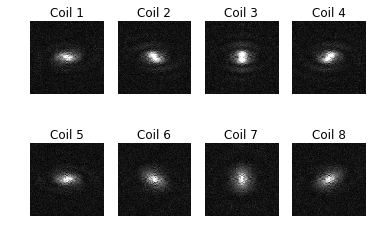

In [8]:
#%% SELECT FIRST REPETITION AND VIEW DATA
k_array = k_array[0:256,:,:]
print('Size of k-space %dx%dx%d' % k_array.shape)

plt.close()
fig = plt.figure(1)
plt.set_cmap('gray')
for c in range(k_array.shape[1]):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(k_array[:,c,:]), vmin=0, vmax=1)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')




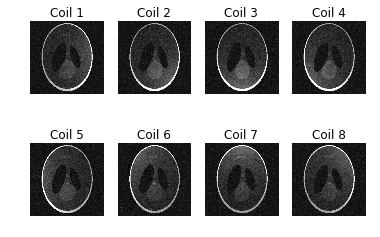

In [9]:
#%% APPLY INVERSE FFT TO EACH COIL AND VIEW IMAGES
image_array = numpy.zeros(k_array.shape, numpy.complex128)
for c in range(k_array.shape[1]):
    image_array[:,c,:] = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(k_array[:,c,:])))
image_array = image_array/image_array.max()
   
fig = plt.figure(2)   
plt.set_cmap('gray')
for c in range(image_array.shape[1]):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(image_array[:,c,:]), vmin=0, vmax=0.4)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
    
    


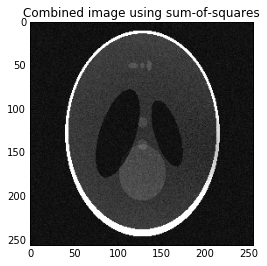

In [10]:
#%% COMBINE COIL IMAGES USING SOS
image_array_sos = abs(numpy.sqrt(numpy.sum(numpy.square(image_array),1)))    
image_array_sos = image_array_sos/image_array_sos.max()

fig = plt.figure(3)
plt.set_cmap('gray')
plt.imshow(image_array_sos, vmin=0, vmax=0.7)
plt.title('Combined image using sum-of-squares') 




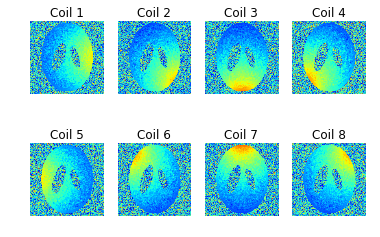

In [11]:
#%% CALCULATE COIL SENSITIVITIES
csm = pMR.CoilSensitivityData()
csm.smoothness = 4
csm.calculate(preprocessed_data)
csm_array = numpy.squeeze(csm.as_array(0))

# csm_array has orientation [coil, im_x, im_y]
csm_array = csm_array.transpose([1,0,2])

fig = plt.figure(4)
plt.set_cmap('jet')
for c in range(csm_array.shape[1]):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(csm_array[:,c,:]))
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')




(-0.5, 255.5, 255.5, -0.5)

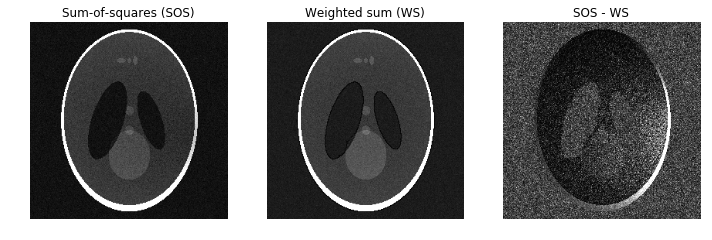

In [12]:
#%% COMBINE COIL IMAGES USING WEIGHTED SUM
image_array_ws = numpy.sum(numpy.multiply(image_array, numpy.conj(csm_array)),1)
image_array_ws = abs(numpy.divide(image_array_ws, numpy.sum(numpy.multiply(csm_array, numpy.conj(csm_array)),1)))
image_array_ws = image_array_ws/image_array_ws.max()

fig = plt.figure(5, figsize=[12, 4])
plt.set_cmap('gray')

ax = fig.add_subplot(1,3,1)
ax.imshow(image_array_sos, vmin=0, vmax=0.7)
ax.set_title('Sum-of-squares (SOS)')
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(image_array_ws, vmin=0, vmax=0.7)
ax.set_title('Weighted sum (WS)')
ax.axis('off')

ax = fig.add_subplot(1,3,3)
ax.imshow(abs(image_array_sos-image_array_ws), vmin=-0, vmax=0.1)
ax.set_title('SOS - WS')
ax.axis('off')





In [ ]:
plt.close('all')